<h2><center>Predicting Home Values in Los Angeles’ South Bay</center></h2>
<h3><center>Springboard | Capstone #1 - Apply Statistics</center></h3>
<h4><center>By: Lauren Broussard</center></h4>

---

As we look to see if we can predict home prices in the South Bay, let's look more closely at a couple of the features involved in home price, and apply some of the statistical inference methods we learned in our Springboard curriculum. 

We will be asking the following questions about our South Bay dataset: 

* **Is there a difference in average home price for homes that sell in the summer vs. non summer months?** 
* **Is there a difference in average home price between "newer" homes vs "older" homes?**  

In [1]:
# load relevant libraries
import pandas as pd
import numpy as np
from datetime import datetime 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set() # set graphs to follow seaborn default view

Let's import our data again and take a quick look at it. 

In [3]:
# import south bay data
south_bay = pd.read_csv('south_bay_cleaned.csv', parse_dates=['SOLD DATE'])
south_bay['ZIP OR POSTAL CODE'] = south_bay['ZIP OR POSTAL CODE'].astype(int)

In [4]:
south_bay.head(3)

,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,PRICE,ZIP OR POSTAL CODE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,MLS#,LATITUDE,LONGITUDE,NEIGHBORHOOD
0,2019-02-01,Single Family Residential,1641 Bay View Ave,Wilmington,730000,90744,7.0,5.0,3401.0,6651.0,2008,358.0,215.0,0.0,SB18278853,33.796254,-118.271532,Wilmington
1,2018-05-31,Single Family Residential,1410 W Sandison St,Wilmington,547000,90744,4.0,2.0,1948.0,5399.0,1962,604.0,281.0,0.0,SB18091442,33.792195,-118.280823,Wilmington
2,2019-10-31,Single Family Residential,1703 N Marine Ave,Wilmington,774000,90744,5.0,3.5,2900.0,5857.0,1940,86.0,267.0,0.0,PW19223929,33.797547,-118.265430,Wilmington


### Summer vs. Non-Summer Sales

We'll begin with our first question: 

**Do homes that sell in the *summer* sell for higher prices (on average) than other months?** We will define summer months as months in June, July, and August, and non-summer months as all other months of the year. 

In [5]:
summer_mos = [6,7,8]
no_summer_mos = [1,2,3,4,9,10,11,12]

summer = south_bay[south_bay['SOLD DATE'].dt.month.isin(summer_mos)]
no_summer = south_bay[south_bay['SOLD DATE'].dt.month.isin(no_summer_mos)]

From our earlier work, we could see that the top months for *number* of home sales seemed to be in the summer months. Let's look at the average home price in each of those months.

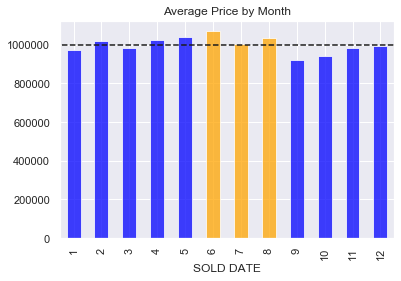

In [6]:
# group months by average price
months = south_bay.groupby(south_bay['SOLD DATE'].dt.month)
monthly_averages = months.aggregate({"PRICE":np.mean})

# assign colors for chart  by month
color = []
for i in range(12):
    if i+1 in summer_mos:
        color.append('orange')
    else:
        color.append('blue')

# plot average price by month
_= monthly_averages.plot(kind='bar',legend=False,color=color,y=0,alpha=0.75)
_= plt.hlines(y=south_bay['PRICE'].mean(),xmin=-1,xmax=12,linestyle='--')
_= plt.title("Average Price by Month")

The average price of homes in the summer months does not seem at first glance to be that different than some other months. Let's look at this further. 

In [7]:
# calculate mean price for each group
obs_summer = np.mean(summer.PRICE)
obs_nosummer = np.mean(no_summer.PRICE)

# calculate difference in means 
obs_diff = obs_summer - obs_nosummer

print("Mean Price, Summer:", obs_summer)
print("Mean Price, Not Summer:", obs_nosummer)
print("Difference in Mean Prices:", obs_diff)

Mean Price, Summer: 1034713.4665672383
Mean Price, Not Summer: 977001.9234021988
Difference in Mean Prices: 57711.543165039504


The mean price between the two groups in our dataset has a difference of $57,788. If the averages were the same, we would expect to see that the difference in mean would be closer to 0. 

We will simulate resampling our data to look at the difference in means between the two groups using Bootstrap inference. We'll first create a function for our test, will create new arrays where we shift the means of the groups by the mean price of all homes. We will then simulate resampling the data 10,000 times. 

<center>We will state our hypotheses, or expectations about the test here: </center>

__NULL HYPOTHESIS:__ There is NO difference in mean home prices in the summer months compared to the rest of the year. 

__ALTERNATE HYPOTHESIS:__ There is a difference in mean home prices in the summer months compared to the rest of the year. 

<center>We will look for a significance level (p-value) of 0.05</center>


In [8]:
# create function to draw bootstrap replicates 

def get_replicates(data,func,size=1):
    """Function to create bootstrap replicates"""  

    # initialize an empty array to store replicates
    bs_replicates = np.empty(size)

    # get n number of bootstrap replicates
    for i in range(size):
        bs_sample = np.random.choice(data, size=len(data))
        bs_replicates[i] = np.mean(bs_sample)
    return bs_replicates

In [9]:
# Compute mean of all prices
obs_avg_price = np.mean(south_bay.PRICE)

# Generate shifted arrays for each group
summer_shifted = summer.PRICE - obs_summer + obs_avg_price
no_summershifted = no_summer.PRICE - obs_nosummer + obs_avg_price 

# Compute 10000 bootstrap replicates from shifted arrays
bs_replicates_summer = get_replicates(summer_shifted, np.mean, size=10000)
bs_replicates_nosummer = get_replicates(summer_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_summer - bs_replicates_nosummer

# Compute and print p-value: p
p = np.sum(bs_replicates >= obs_diff) / 10000
print('Mean difference between groups, p-value:', p)

Mean difference between groups, p-value: 0.0018


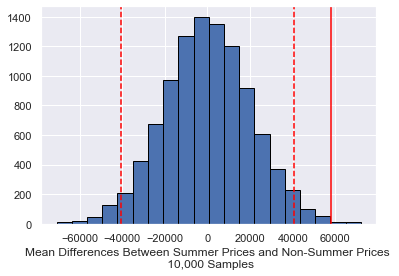

In [10]:
# calculate confidence intervals
intv = np.percentile(bs_replicates,[2.5,97.5])
_= plt.hist(bs_replicates,bins=20,ec='black')
_= plt.xlabel("Mean Differences Between Summer Prices and Non-Summer Prices \n 10,000 Samples")
_= plt.axvline(obs_diff,color='red')
_= plt.axvline(intv[0],linestyle='--',color ='red')
_= plt.axvline(intv[1],linestyle='--',color='red')
plt.show()

Based on our results above, with a p-value of 0.002 and since the difference in means is outside of our confidence interval, we will reject the null hypothesis that there is no difference between the means. 

______

### Newer vs. Older Homes (Redondo Beach)

Let's turn our attention to the year a home was built. We will look at one neighborhood here, Redondo Beach, that has a large number of home sales (n~1800) compared to other neighborhoods. 

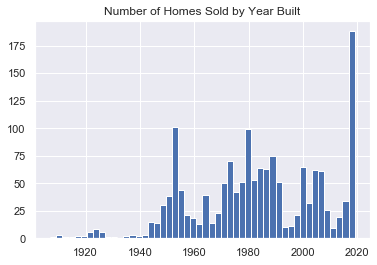

In [11]:
# show number of homes built by year
neighborhood_name = 'Redondo Beach'
neighborhood = south_bay[south_bay['NEIGHBORHOOD'] == neighborhood_name]
_= neighborhood.hist('YEAR BUILT',bins=50)
_= plt.title('Number of Homes Sold by Year Built')

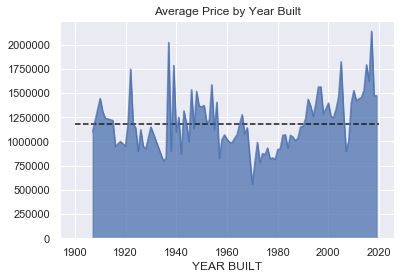

In [12]:
# display average home price by year 

years = neighborhood.groupby('YEAR BUILT')
yearly_averages = years.aggregate({"PRICE":np.mean})

_= yearly_averages.plot(kind='area',legend=False,y=0,alpha=0.75)
_= plt.hlines(y=neighborhood['PRICE'].mean(),xmin=1900,xmax=2020,linestyle='--')
_= plt.title("Average Price by Year Built")

The home prices seem to fluctuate over the years, though seem to have a more steady increase after about 2000, after a large dip.

Let's use homes built before 2000 vs homes built after 2000 as our two groups. Again, we will do a bootstrap test to look at the difference in means between the two groups. 

<center>We will state our hypotheses, or expectations about this new test here: </center>

__NULL HYPOTHESIS:__ There is NO difference in mean home prices between homes built before or in 2000 and homes built after 2000.

__ALTERNATE HYPOTHESIS:__ There is a difference in mean home prices between homes built before or in 2000 and homes built after 2000. 

Again, we'll look for a significance level of 0.05.

In [13]:
# create two groups, built in or before a certain date, and those built after. 
date = 2000
during_prior = neighborhood[neighborhood['YEAR BUILT'] <= date]
after = neighborhood[neighborhood['YEAR BUILT'] > date]

In [14]:
# get means and average difference between groups
obs_during_prior = np.mean(during_prior.PRICE)
obs_after = np.mean(after.PRICE)

# calculate difference in means 
obs_diff2 = obs_after - obs_during_prior

print("Mean Price, 2000 and before:", obs_during_prior)
print("Mean Price, After 2000:", obs_after)
print("Difference in Mean Prices:", obs_diff2)

Mean Price, 2000 and before: 1078491.7327971403
Mean Price, After 2000: 1450324.140311804
Difference in Mean Prices: 371832.40751466365


The observed difference in price between newer homes and older homes is about $381,832.

We'll use our earlier *get_replicates* method to rerun our samples 10,000 times. 

In [15]:
obs_avg_price2 = np.mean(south_bay.PRICE)

# Generate shifted arrays for each group
shifted_during_prior = during_prior.PRICE - obs_during_prior + obs_avg_price2
shifted_after = after.PRICE - obs_after + obs_avg_price2 

# Compute 10000 bootstrap replicates from shifted arrays
bs_replicates_during_prior = get_replicates(shifted_during_prior, np.mean, size=10000)
bs_replicates_after = get_replicates(shifted_after, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates2 = bs_replicates_after - bs_replicates_during_prior

# Compute and print p-value: p
p = np.sum(bs_replicates2 >= obs_diff2) / 10000
print('Mean difference between groups, p-value:', p)

Mean difference between groups, p-value: 0.0


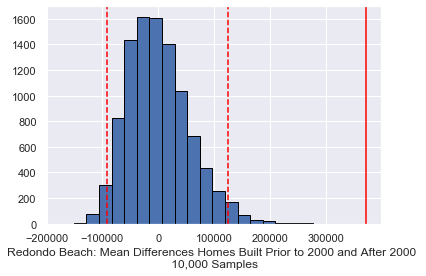

In [16]:
# calculate confidence intervals
intv = np.percentile(bs_replicates2,[2.5,97.5])
_= plt.hist(bs_replicates2,bins=20,ec='black')
_= plt.xlabel("Redondo Beach: Mean Differences Homes Built Prior to 2000 and After 2000 \n 10,000 Samples")
_= plt.axvline(obs_diff2,color='red')
_= plt.axvline(intv[0],linestyle='--',color ='red')
_= plt.axvline(intv[1],linestyle='--',color='red')
plt.show()

Based on this information, and a p-value of 0.0, we would reject the null hypothesis that there is no difference in average price between homes built before 2000 and those built after in this particular neighborhood in Redondo Beach.

-----